In [ ]:
!pip install transformers datasets
# Importing necessary libraries with updated names
import pandas as pd
from sklearn.model_selection import train_test_split as emotion_split
from transformers import BertTokenizer as EmotionBertTokenizer, BertForSequenceClassification as EmotionBertForSequenceClassification, Trainer as EmotionTrainer, TrainingArguments as EmotionTrainingArguments
from transformers import DataCollatorWithPadding as EmotionDataCollatorWithPadding
from sklearn.metrics import accuracy_score as emotion_accuracy_score, f1_score as emotion_f1_score, confusion_matrix as emotion_confusion_matrix
import matplotlib.pyplot as emotion_plt
import seaborn as emotion_sns
import numpy as emotion_np
import torch as emotion_torch
import datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requ

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch

In [ ]:
def load_and_preprocess_emotion_data(file_path):
    """
    Load and preprocess the Emotion dataset.

    Args:
    file_path (str): Path to the dataset file.

    Returns:
    train_emotion_dataset, test_emotion_dataset (HuggingFace Datasets): Preprocessed datasets.
    """
    # Load dataset from the CSV file
    emotion_df = pd.read_csv(file_path)

    # Renaming columns to be more descriptive
    emotion_df.columns = ['emotion_text', 'emotion_label']

    # Splitting the dataset into training and testing sets
    train_emotion_df, test_emotion_df = emotion_split(emotion_df, test_size=0.20, random_state=42)

    # Convert DataFrame to lists for compatibility with HuggingFace Dataset format
    train_texts = train_emotion_df['emotion_text'].tolist()
    train_labels = train_emotion_df['emotion_label'].tolist()
    test_texts = test_emotion_df['emotion_text'].tolist()
    test_labels = test_emotion_df['emotion_label'].tolist()

    # Tokenize the data
    emotion_tokenizer = EmotionBertTokenizer.from_pretrained('bert-base-uncased')

    def tokenize_function(texts, labels):
        # Tokenize the text
        tokenized_inputs = emotion_tokenizer(texts, truncation=True, padding=True)
        # Add labels
        tokenized_inputs['labels'] = labels
        return tokenized_inputs

    # Tokenize the datasets
    train_encodings = tokenize_function(train_texts, train_labels)
    test_encodings = tokenize_function(test_texts, test_labels)

    # Determine unique labels from your dataset
    unique_labels = set(train_encodings['labels'])

    # Create a mapping from labels to integers
    label_mapping = {label: i for i, label in enumerate(unique_labels)}

    # Convert labels to integers using the mapping
    train_encodings['labels'] = [label_mapping[label] for label in train_encodings['labels']]
    test_encodings['labels'] = [label_mapping[label] for label in test_encodings['labels']]

    # Convert tokenized data to HuggingFace Datasets
    train_dataset = datasets.Dataset.from_dict(train_encodings)
    test_dataset = datasets.Dataset.from_dict(test_encodings)

    return train_dataset, test_dataset, emotion_tokenizer, test_emotion_df

def train_emotion_model(train_encodings, test_encodings, tokenizer):
    """
    Train the Emotion classification model using a BERT transformer.

    Args:
    train_encodings, test_encodings (Dict): Encoded datasets for training and testing.
    tokenizer (EmotionBertTokenizer): BERT tokenizer used for tokenizing text data.

    Returns:
    EmotionTrainer: Trainer object after training is complete.
    """
    # Data collator for padding sequences
    emotion_data_collator = EmotionDataCollatorWithPadding(tokenizer=tokenizer)

    # Loading pre-trained BERT model for emotion classification
    emotion_model = EmotionBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

    def compute_emotion_metrics(p):
      return {
          'accuracy': emotion_accuracy_score(p.label_ids, emotion_np.argmax(p.predictions, axis=1)),
          'f1': emotion_f1_score(p.label_ids, emotion_np.argmax(p.predictions, axis=1), average='weighted')
      }

    # Defining training arguments for the emotion analysis model
    emotion_training_args = EmotionTrainingArguments(
        output_dir='./emotion_results',
        eval_strategy="epoch",
        logging_dir='./emotion_logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=2,
        weight_decay=0.01,

    )

    # Initializing the Trainer for fine-tuning the emotion model
    emotion_trainer = EmotionTrainer(
        model=emotion_model,
        args=emotion_training_args,
        train_dataset=train_encodings,
        eval_dataset=test_encodings,
        tokenizer=tokenizer,
        data_collator=emotion_data_collator,
        compute_metrics=compute_emotion_metrics
    )

    # Training the emotion classification model
    emotion_trainer.train()

    return emotion_trainer

def evaluate_emotion_model(trainer, test_encodings, test_df):
    """
    Evaluate the trained Emotion model and generate a confusion matrix.

    Args:
    trainer (EmotionTrainer): Trainer object after training.
    test_encodings (Dict): Encoded test dataset.
    test_df (pd.DataFrame): Original test DataFrame for comparison.

    Returns:
    None
    """
    # Evaluating the model's performance
    emotion_results = trainer.evaluate()

    # Generating predictions and a confusion matrix
    emotion_predictions = trainer.predict(test_encodings)
    emotion_y_true = emotion_predictions.label_ids  # Removed .cpu() as it's already a NumPy array
    emotion_y_pred = emotion_np.argmax(emotion_predictions.predictions, axis=1)

    emotion_conf_matrix = emotion_confusion_matrix(emotion_y_true, emotion_y_pred)

    # Plotting the confusion matrix in green color
    emotion_plt.figure(figsize=(8, 6))
    emotion_sns.heatmap(emotion_conf_matrix, annot=True, fmt="d", cmap="Greens")
    emotion_plt.title("Emotion Classification Confusion Matrix")
    emotion_plt.xlabel("Predicted Emotion Label")
    emotion_plt.ylabel("True Emotion Label")
    emotion_plt.show()

    # Displaying sample results from the test set
    for i in range(5):
        print(f"Text: {test_df.iloc[i]['emotion_text']}")
        print(f"True Label: {test_df.iloc[i]['emotion_label']}, Predicted Label: {emotion_y_pred[i]}")
        print("---")

    # Printing evaluation metrics
    print("Accuracy:", emotion_results['eval_accuracy'])
    print("F1 Score:", emotion_results['eval_f1'])


In [ ]:
# Load and preprocess the emotion dataset
train_encodings, test_encodings, emotion_tokenizer, test_emotion_df = load_and_preprocess_emotion_data('/content/drive/My Drive/Emotion_classify_Data.csv')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Train the emotion classification model
emotion_trainer = train_emotion_model(train_encodings, test_encodings, emotion_tokenizer)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.339900,0.135390,0.958754,0.958863
2,0.080300,0.146642,0.964646,0.964748


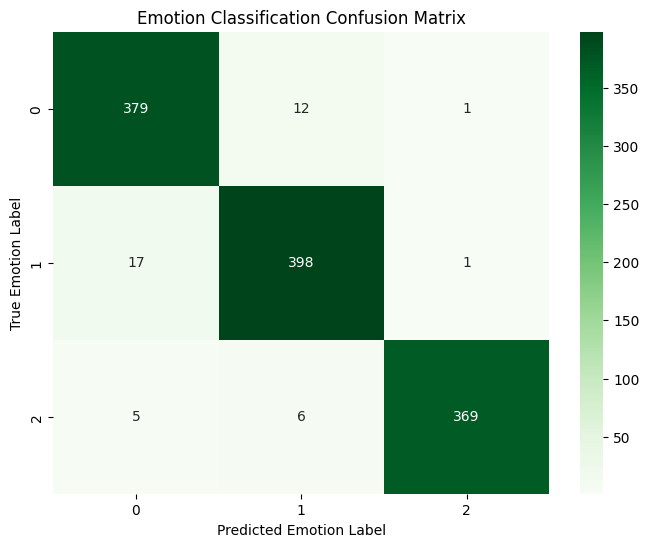

Text: i do give up at times when i feel there s no point in a friendship when one cant be bothered
True Label: anger, Predicted Label: 0
---
Text: im a firm believer that nothing makes a woman feel much more terrific than a great trip to the salon to lift her spirits a bit
True Label: joy, Predicted Label: 2
---
Text: i was feeling very vulnerable and down no one really close to me has ever died before i either hadnt known them very well or was too young to remember
True Label: fear, Predicted Label: 1
---
Text: i closed her eyes in anger and feeling disgusted by this touch
True Label: anger, Predicted Label: 0
---
Text: i feel like being distracted
True Label: anger, Predicted Label: 0
---
Accuracy: 0.9646464646464646
F1 Score: 0.96474807805056


In [ ]:
# Evaluate the emotion model and display results
evaluate_emotion_model(emotion_trainer, test_encodings, test_emotion_df)